## Evaluating GPT Prompts

In [118]:
import pandas as pd
import numpy as np
import re
import warnings
import seaborn as sns
import matplotlib as plt
#from sklearn.metrics import plot_confusion_matrix


Here, I will be going through the model's outputs for different combinations of prompts and trying to evaluate them against human coding and as well as each other.

First, the model's responses needs to be standardised so it can be compared easily. We can look at the format of the responses for each prompt combination below:

In [2]:
role_simple_context = pd.read_excel("./outputs/role_simple_context_30.xlsx")
role_simple_context_ex = pd.read_excel("./outputs/role_simple_context_ex_30.xlsx")
role_detailed_context= pd.read_excel("./outputs/role_detailed_context_30.xlsx")
role_detailed_context_ex= pd.read_excel("./outputs/role_detailed_context_ex_30.xlsx")
story_prompt = pd.read_excel("./outputs/story_prompt.xlsx")
story_prompt_ex = pd.read_excel("./outputs/story_prompt_ex.xlsx")

A look at the coding framework provided:

In [3]:
simple_context_prompt = open("./prompts/simple_context_prompt.txt").read()
print(simple_context_prompt)

Code the provided texts using the provided list of codes. Your task is to match each text in the dataset to one or more codes from the provided list, based on the content of the text. Use your judgment to determine which codes are most appropriate for each text, and provide a summary of your coding results in a clear and organized manner.

1	Not comfortable with him taking the pill - no specific reason given
2	Not comfortable with him taking the pill - changing something fundamental
3	Not comfortable with him taking the pill - changing the brain
4	Not comfortable with him taking the pill - side effect
5	Not comfortable with him taking the pill - general concerns about pills
6	Not comfortable with him taking the pill - no need, nor medically necessary
7	Not comfortable with him taking the pill - naturalistic moral concerns
8	Not comfortable with him taking the pill - risks outweight the benefits
9	Not comfortable with him taking the pill - dependence, addiction
10	Not comfortable with h

### Examining responses
Below, we look at the format of responses to see how to best compare them.

In [4]:
role_simple_context["Response"].head()

0    \n2\tNot comfortable with him taking the pill ...
1     2, 5, 6, 7, 10, 11, 12, 13, 15, 17, 18, 19, 2...
2    \n\n2\tNot comfortable with him taking the pil...
3     2, 5, 6, 7, 8, 10, 13, 14, 15\n\nThe text pro...
4                       2, 4, 5, 6, 10, 14, 15, 24, 28
Name: Response, dtype: object

In [5]:
role_simple_context_ex["Response"].head()

0     6\tNot comfortable with him taking the pill -...
1     6\tNot comfortable with him taking the pill -...
2     6\tNot comfortable with him taking the pill -...
3     6\tNot comfortable with him taking the pill -...
4     4\tNot comfortable with him taking the pill -...
Name: Response, dtype: object

In [6]:
role_detailed_context["Response"].head()

0                                              6, 7, 8
1     6 Not comfortable with him taking the pill - ...
2     6 Not comfortable with him taking the pill - ...
3     2 Not comfortable with him taking the pill - ...
4     2 Not comfortable with him taking the pill - ...
Name: Response, dtype: object

In [7]:
role_detailed_context_ex["Response"].head()

0     6\tNot comfortable with him taking the pill â...
1     6\tNot comfortable with him taking the pill â...
2     6\tNot comfortable with him taking the pill â...
3     6\tNot comfortable with him taking the pill â...
4     4\tNot comfortable with him taking the pill -...
Name: Response, dtype: object

In [8]:
story_prompt["Response"].head()

0                                             6, 7, 10
1                                        6, 10, 13, 15
2     6 Not comfortable with him taking the pill - ...
3                                           2, 6, 7, 8
4                             5, 8, 10, 15, 24, 27, 29
Name: Response, dtype: object

In [9]:
story_prompt_ex["Response"].head()

0     6\tNot comfortable with him taking the pill â...
1     6\tNot comfortable with him taking the pill â...
2     6\tNot comfortable with him taking the pill â...
3     6\tNot comfortable with him taking the pill â...
4     4\tNot comfortable with him taking the pill -...
Name: Response, dtype: object

In [10]:
print(role_simple_context["Response"][9])

 18, 19, 21, 22, 23, 24, 25, 28

Text: Not comfortable with him taking the pill - no specific reason givenCodes: 2, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 9


In [11]:
print(role_simple_context_ex["Response"][9])

 18	Comfortable with him taking the pill - his choice; 19	Comfortable with him taking the pill - minor or no side effects; 21	Comfortable with him taking the pill - positive benefits; 22	Comfortable with him taking the pill - nothing wrong with using science or other means to improve ourselves; 23	Comfortable with him taking the pill - benefits outweight the risks; 24	Comfortable with him taking the pill - consent/informed decision; 27	Comfortable with him taking the pill - no harm to himself or others.


In [12]:
print(role_detailed_context["Response"][9])

 17, 18, 19, 20, 21, 22, 24, 27, 28


In [13]:
print(role_detailed_context_ex["Response"][9])

 18	Comfortable with him taking the pill - his choice; 21	Comfortable with him taking the pill - positive benefits; 22	Comfortable with him taking the pill - nothing wrong with using science or other means to improve ourselves; 24	Comfortable with him taking the pill - consent/informed decision.


In [14]:
print(story_prompt["Response"][9])

 17, 19, 22, 24, 26


In [15]:
print(story_prompt_ex["Response"][9])

 18	Comfortable with him taking the pill - his choice; 21	Comfortable with him taking the pill - positive benefits; 24	Comfortable with him taking the pill - consent/informed decision


Overall, it appears the responses are a lot more standardised when an example is given. When the description is given along with the number, the description appears to usually match the number.

I will *assume* that the number matches the description, and extract the numbers out to have an easy method of comparison.

One may ask why the examples had descriptions, if I was just going to remove them in the responses. The descriptions were kept based on tests in the OpenAI Playground, where examples with only numbers appeared to lead to more arbitrary responses (strings of numbers, some of which matched the example, but which did not make sense in connecting to the rest of the prompt). This makes sense in context of previous findings that GPT models do better when asked to 'reason step-by-step' or otherwise explain their answers.

#TODO may add another prompt with explicit 'explain your answer'. Add after setting up eval code.

### Standardising responses

In [35]:
dat_list = [
    role_simple_context,
    role_simple_context_ex,
    role_detailed_context,
    role_detailed_context_ex,
    story_prompt,
    story_prompt_ex]

dat_names = [
    "role_simple_context",
    "role_simple_context_ex",
    "role_detailed_context",
    "role_detailed_context_ex",
    "story_prompt",
    "story_prompt_ex"]

In [17]:
def get_codes(data):
    dat_coded = data.copy()
    responses = dat_coded["Response"]
    dat_coded["Codes"] = np.nan
    for i in range(len(responses)):
        comment = responses[i]
        codes = re.findall(r'\d+', comment)
        dat_coded["Codes"][i] = codes
    return dat_coded

Note - some comments may have numbers that are not codes (e.g. 'text 1'). May want to consider this when optimising codes at the end.

**One Hot Encoding**
Now there is a list of numbers under the 'codes' column for each comment. For easier comparison, this will be transformed into one-hot-encoded columns like for the human-coded preprocessed data.

In [18]:
def add_ohe_cols(dat):
    dat_cols = dat.copy()
    zeroes = [0]*len(dat_cols)
    #print(len(zeroes))
    dat_cols['Not Comfortable with (0)']= zeroes#[0]*len(dat_cols),
    dat_cols['Not Comfortable with (1)']= zeroes
    dat_cols['Not Comfortable with (2)']= zeroes
    dat_cols['Not Comfortable with (3)']= zeroes
    dat_cols['Not Comfortable with (4)']= zeroes
    dat_cols['Not Comfortable with (5)']= zeroes
    dat_cols['Not Comfortable with (6)']= zeroes
    dat_cols['Not Comfortable with (7)']= zeroes
    dat_cols['Not Comfortable with (8)']= zeroes
    dat_cols['Not Comfortable with (9)']= zeroes
    dat_cols['Not Comfortable with (10)']= zeroes
    dat_cols['Not Comfortable with (11)']= zeroes
    dat_cols['Not Comfortable with (12)']= zeroes
    dat_cols['Not Comfortable with (13)']= zeroes
    dat_cols['Not Comfortable with (14)']= zeroes
    dat_cols['Comfortable with (0)']= zeroes
    dat_cols['Comfortable with (1)']= zeroes
    dat_cols['Comfortable with (2)']= zeroes
    dat_cols['Comfortable with (3)']= zeroes
    dat_cols['Comfortable with (4)']= zeroes
    dat_cols['Comfortable with (5)']= zeroes
    dat_cols['Comfortable with (6)']= zeroes
    dat_cols['Comfortable with (7)']= zeroes
    dat_cols['Comfortable with (8)']= zeroes
    dat_cols['Comfortable with (9)']= zeroes
    dat_cols['Comfortable with (10)']= zeroes
    dat_cols['Comfortable with (11)']= zeroes
    dat_cols['Comfortable with (12)']= zeroes
    dat_cols['Other (binary)']= zeroes
    return dat_cols


    
def one_hot_encode(dat):
    dat_ohe = dat.copy()
    for i in range(len(dat_ohe)):
        #print(dat_ohe["Codes"][i])
        if '1' in dat_ohe["Codes"][i]:
            dat_ohe["Not Comfortable with (0)"][i] = 1
        if '2' in dat_ohe["Codes"][i]:
            dat_ohe["Not Comfortable with (1)"][i] = 1
        if '3' in dat_ohe["Codes"][i]:
            dat_ohe["Not Comfortable with (2)"][i] = 1
        if '4' in dat_ohe["Codes"][i]:
            dat_ohe["Not Comfortable with (3)"][i] = 1
        if '5' in dat_ohe["Codes"][i]:
            dat_ohe["Not Comfortable with (4)"][i] = 1
        if '6' in dat_ohe["Codes"][i]:
            dat_ohe["Not Comfortable with (5)"][i] = 1
        if '7' in dat_ohe["Codes"][i]:
            dat_ohe["Not Comfortable with (6)"][i] = 1
        if '8' in dat_ohe["Codes"][i]:
            dat_ohe["Not Comfortable with (7)"][i] = 1
        if '9' in dat_ohe["Codes"][i]:
            dat_ohe["Not Comfortable with (8)"][i] = 1
        if '10' in dat_ohe["Codes"][i]:
            dat_ohe["Not Comfortable with (9)"][i] = 1
        if '11' in dat_ohe["Codes"][i]:
            dat_ohe["Not Comfortable with (10)"][i] = 1
        if '12' in dat_ohe["Codes"][i]:
            dat_ohe["Not Comfortable with (11)"][i] = 1
        if '13' in dat_ohe["Codes"][i]:
            dat_ohe["Not Comfortable with (12)"][i] = 1
        if '14' in dat_ohe["Codes"][i]:
            dat_ohe["Not Comfortable with (13)"][i] = 1
        if '15' in dat_ohe["Codes"][i]:
            dat_ohe["Not Comfortable with (14)"][i] = 1
        if '16' in dat_ohe["Codes"][i]:
            dat_ohe["Comfortable with (0)"][i] = 1
        if '17' in dat_ohe["Codes"][i]:
            dat_ohe["Comfortable with (1)"][i] = 1
        if '18' in dat_ohe["Codes"][i]:
            dat_ohe["Comfortable with (2)"][i] = 1
        if '19' in dat_ohe["Codes"][i]:
            dat_ohe["Comfortable with (3)"][i] = 1
        if '20' in dat_ohe["Codes"][i]:
            dat_ohe["Comfortable with (4)"][i] = 1
        if '21' in dat_ohe["Codes"][i]:
            dat_ohe["Comfortable with (5)"][i] = 1
        if '22' in dat_ohe["Codes"][i]:
            dat_ohe["Comfortable with (6)"][i] = 1
        if '23' in dat_ohe["Codes"][i]:
            dat_ohe["Comfortable with (7)"][i] = 1
        if '24' in dat_ohe["Codes"][i]:
            dat_ohe["Comfortable with (8)"][i] = 1
        if '25' in dat_ohe["Codes"][i]:
            dat_ohe["Comfortable with (9)"][i] = 1
        if '26' in dat_ohe["Codes"][i]:
            dat_ohe["Comfortable with (10)"][i] = 1
        if '27' in dat_ohe["Codes"][i]:
            dat_ohe["Comfortable with (11)"][i] = 1
        if '28' in dat_ohe["Codes"][i]:
            dat_ohe["Comfortable with (12)"][i] = 1
        if '29' in dat_ohe["Codes"][i]:
            dat_ohe["Other (binary)"][i] = 1
    return dat_ohe
            

for d in dat_list:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        one_hot_encode(add_ohe_cols(get_codes(d)))

In [37]:
#WARNING ignored: A value is trying to be set on a copy of a slice from a DataFrame

processed = {}
for i in range(len(dat_list)):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        processed[dat_names[i]] = one_hot_encode(add_ohe_cols(get_codes(dat_list[i])))


## Evaluation

Below, I define functions to produce confusion matrices, and calculate accuracy, recall and precision, for each set of model responses. These are calculated in by comparing to a set of human-coded responses, so each of these metrices only compares how similar the model's responses are to a human's. Even if they are low, it is possible that the model's response is justifiable, as coding for qualitative analysis can differ widely between different (human) coders and requires subjective judgement.

Accuracy considers how many of the model's responses match the human's. Recall considers, among all the codes the human chose for a comment, how many did the model also choose? Precision considers, among all the codes the model chose for a comment, how many did the human also choose?

If the model skews towards choosing a lot of codes, then recall will be high, but precision will be low. A good model should therefore have relatively high precision as well as accuracy and recall.

In [100]:
#Get true positive/negative and false positive/negative comparing the first to the second dataset
def get_metrics(model_dat, human_dat):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    
    code_columns=[
    'Not Comfortable with (0)',
    'Not Comfortable with (1)',
    'Not Comfortable with (2)',
    'Not Comfortable with (3)',
    'Not Comfortable with (4)',
    'Not Comfortable with (5)',
    'Not Comfortable with (6)',
    'Not Comfortable with (7)',
    'Not Comfortable with (8)',
    'Not Comfortable with (9)',
    'Not Comfortable with (10)',
    'Not Comfortable with (11)',
    'Not Comfortable with (12)',
    'Not Comfortable with (13)',
    'Not Comfortable with (14)',
    'Comfortable with (0)',
    'Comfortable with (1)',
    'Comfortable with (2)',
    'Comfortable with (3)',
    'Comfortable with (4)',
    'Comfortable with (5)',
    'Comfortable with (6)',
    'Comfortable with (7)',
    'Comfortable with (8)',
    'Comfortable with (9)',
    'Comfortable with (10)',
    'Comfortable with (11)',
    'Comfortable with (12)',
    'Other (binary)']

    for i in range(len(model_dat)):
        for c in code_columns:
            if model_dat[c][i] == human_dat[c][i]:
                if model_dat[c][i] == 1:
                    true_positives += 1
                elif model_dat[c][i] == 0:
                    true_negatives += 1
            elif model_dat[c][i] != human_dat[c][i]:
                if model_dat[c][i] == 1:
                    false_positives += 1
                elif model_dat[c][i] == 0:
                    false_negatives += 1
    metrics = {
        "true_positives":true_positives,
        "true_negatives":true_negatives,
        "false_positives":false_positives,
        "false_negatives":false_negatives
    }
    
    return metrics
    

In [110]:
#function to calculate accuracy by calling the above
#returns nothing
def get_accuracy(model_dat, human_dat):
    mets = get_metrics(model_dat, human_dat)
    print("Accuracy:", 
      (mets["true_positives"]+mets["true_negatives"])/
          (mets["true_positives"]+mets["true_negatives"]+mets["false_positives"]+mets["false_negatives"])
     )

#function to calculate recall
#'Among all positive examples, how many did you identify?'
#returns nothing
def get_recall(model_dat, human_dat):
    mets = get_metrics(model_dat, human_dat)
    print("Recall:", 
      (mets["true_positives"])/
          (mets["true_positives"]+mets["false_negatives"])
     )
    
#function to calculate precision
#'Among the positive examples you identified, how many were actually positive?'
#returns nothing
def get_precision(model_dat, human_dat):
    mets = get_metrics(model_dat, human_dat)
    print("Precision:", 
      (mets["true_positives"])/
          (mets["true_positives"]+mets["false_positives"])
     )
    
#function to produce dataframe version of metrics above
#returns the df
def get_df_metrics(model_dat, human_dat):
    mets = get_metrics(model_dat, human_dat)
    mets_df = pd.DataFrame(
        data = [[mets["true_negatives"], mets["false_positives"]],
                [mets["false_negatives"], mets["true_positives"]]],
        index = ["Actual False", "Actual True"],
        columns = ["Predicted False", "Predicted True"])
    #print(mets_df)
    return mets_df

#function to plot the confusion matrix as a heatmap, calls above functions
#returns nothing
def conf_matrix_heatmap(model_dat, human_dat):
    mets_df = get_df_metrics(model_dat, human_dat)
    sns.heatmap(mets_df, annot=True)

In [102]:
#Read human data to compare to:
human_data = pd.read_csv("../data/data_preprocessed.csv")

In [113]:
#All the model response datasets:
processed.keys()

dict_keys(['role_simple_context', 'role_simple_context_ex', 'role_detailed_context', 'role_detailed_context_ex', 'story_prompt', 'story_prompt_ex'])

Metrics for  role_simple_context
Accuracy: 0.6241379310344828
Recall: 0.7049180327868853
Precision: 0.12215909090909091


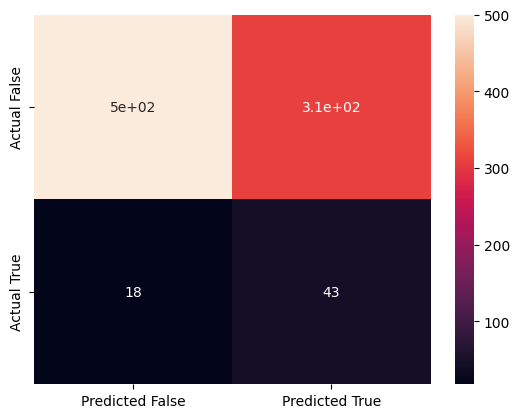

Metrics for  role_simple_context_ex
Accuracy: 0.828735632183908
Recall: 0.6229508196721312
Precision: 0.23170731707317074


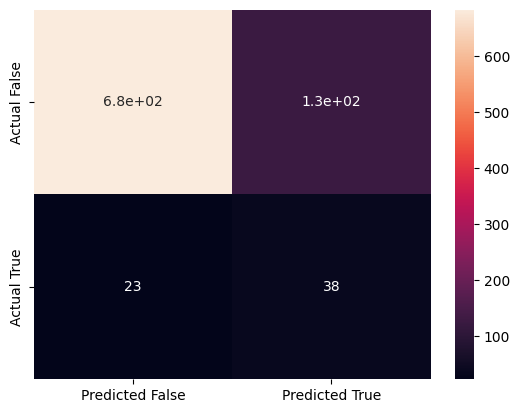

Metrics for  role_detailed_context
Accuracy: 0.8310344827586207
Recall: 0.5737704918032787
Precision: 0.22435897435897437


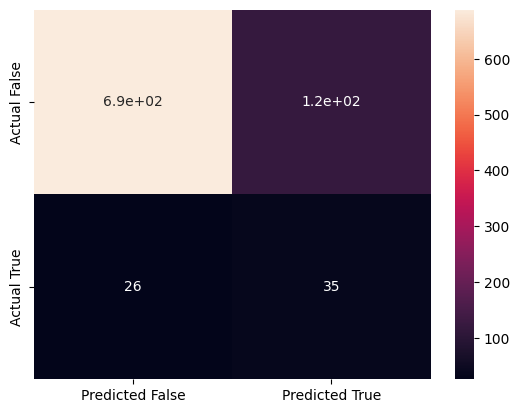

Metrics for  role_detailed_context_ex
Accuracy: 0.8896551724137931
Recall: 0.6721311475409836
Precision: 0.3504273504273504


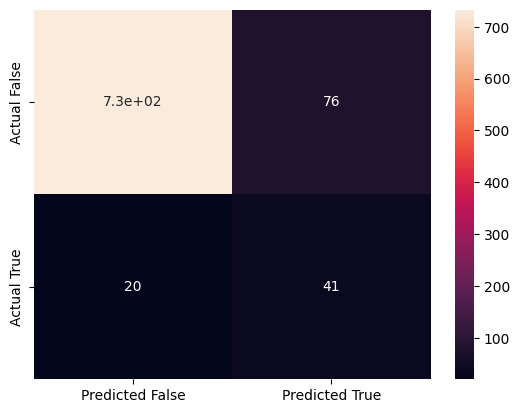

Metrics for  story_prompt
Accuracy: 0.867816091954023
Recall: 0.6229508196721312
Precision: 0.2923076923076923


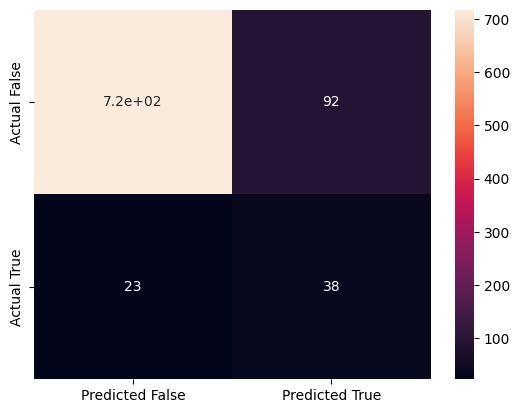

Metrics for  story_prompt_ex
Accuracy: 0.9241379310344827
Recall: 0.6721311475409836
Precision: 0.47126436781609193


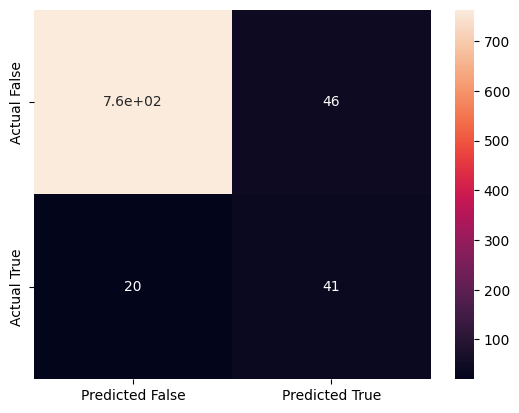

In [119]:
for k in processed.keys():
    print("Metrics for ", k)
    get_accuracy(processed[k], human_data)
    get_recall(processed[k], human_data)
    get_precision(processed[k], human_data)
    conf_matrix_heatmap(processed[k], human_data)
    plt.pyplot.show()